# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from rnn_layers import *
from captioning_solver import CaptioningSolver
from classifiers.rnn import CaptioningRNN
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
data = load_coco_data(pca_features=True) # pcs_features= False

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

OSError: Unable to open file (unable to open file: name = './datasets/coco_captioning/coco2014_captions.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 39.716376
(Iteration 21 / 100) loss: 22.292283
(Iteration 31 / 100) loss: 6.781151
(Iteration 41 / 100) loss: 2.183451
(Iteration 51 / 100) loss: 0.506159
(Iteration 61 / 100) loss: 0.198000
(Iteration 71 / 100) loss: 0.095487
(Iteration 81 / 100) loss: 0.082117
(Iteration 91 / 100) loss: 0.046350


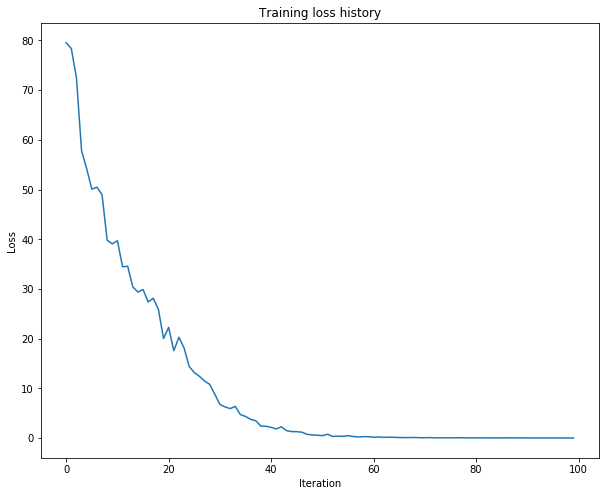

In [3]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

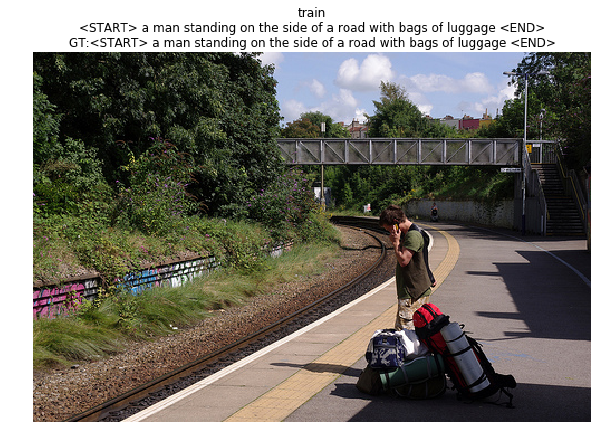

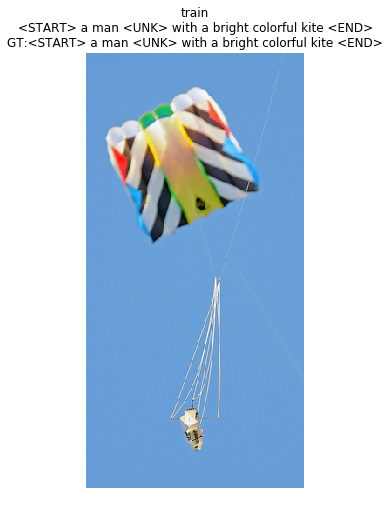

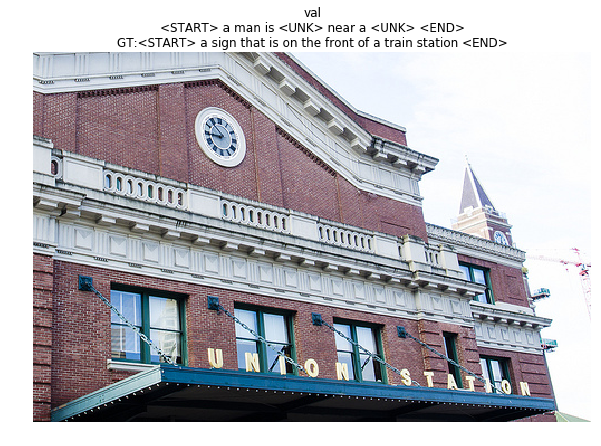

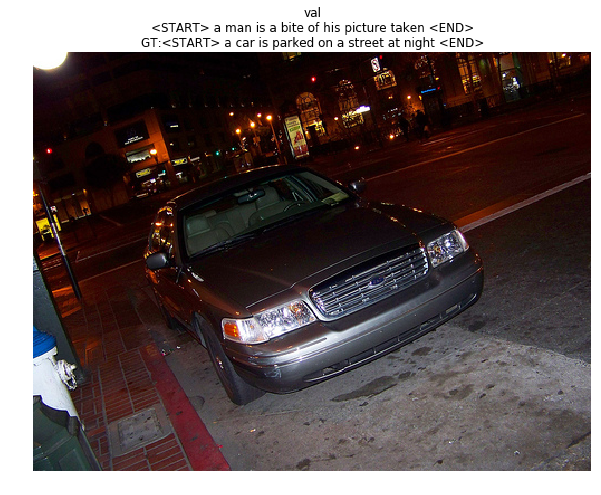

In [39]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Extra Credit: Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. We'll give you a small amount of extra credit if you can train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch or TensorFlow for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for TensorFlow/PyTorch if you go that route.

In [7]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [9]:
np.random.seed(231)

data = load_coco_data()

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=25,
           batch_size=128,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )
lstm_solver.train()

# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 78150) loss: 76.893173
(Iteration 101 / 78150) loss: 33.125469
(Iteration 201 / 78150) loss: 30.169975
(Iteration 301 / 78150) loss: 30.451328
(Iteration 401 / 78150) loss: 28.824917
(Iteration 501 / 78150) loss: 29.590760
(Iteration 601 / 78150) loss: 29.198437
(Iteration 701 / 78150) loss: 28.940937
(Iteration 801 / 78150) loss: 28.579056
(Iteration 901 / 78150) loss: 28.550907
(Iteration 1001 / 78150) loss: 27.965242
(Iteration 1101 / 78150) loss: 27.529464
(Iteration 1201 / 78150) loss: 28.094898
(Iteration 1301 / 78150) loss: 26.410408
(Iteration 1401 / 78150) loss: 28.764663
(Iteration 1501 / 78150) loss: 26.738010
(Iteration 1601 / 78150) loss: 27.313256
(Iteration 1701 / 78150) loss: 26.804863
(Iteration 1801 / 78150) loss: 26.031640
(Iteration 2201 / 78150) loss: 26.283177
(Iteration 2301 / 78150) loss: 28.290825
(Iteration 2401 / 78150) loss: 26.874582
(Iteration 2501 / 78150) loss: 28.184986
(Iteration 2601 / 78150) loss: 26.213184
(Iteration 2701 / 78150) los

KeyboardInterrupt: 

In [8]:
import nltk

evaluate_model(small_lstm_model)

Average BLEU score for train: 0.177228
Average BLEU score for val: 0.174437


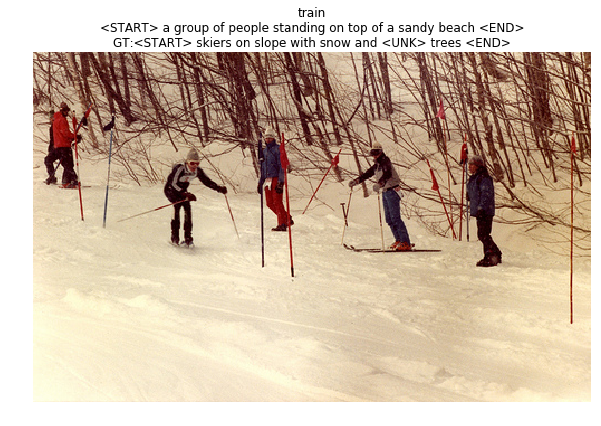

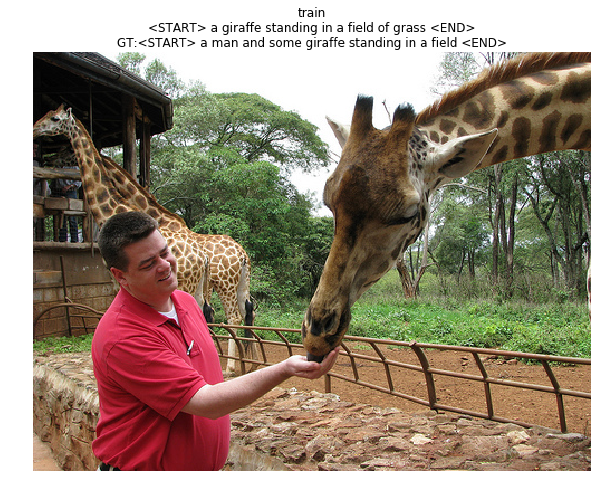

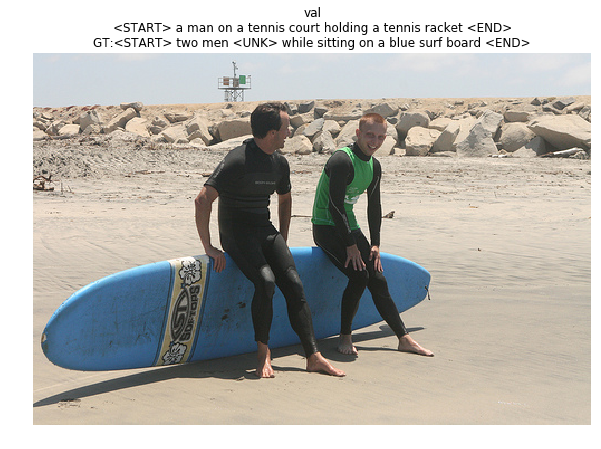

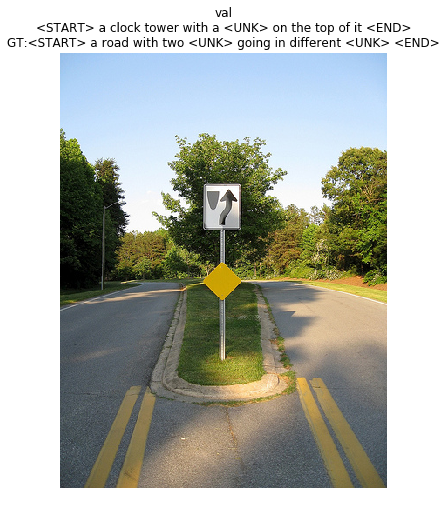

In [18]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()